In [2]:

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

In [3]:
class layer(object):

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def __init__(self, n_inputs, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.weights = np.random.rand(n_inputs, n_outputs)
        self.biases = np.zeros((1, n_outputs))

        self.cost_gradient_weights = np.zeros((n_inputs, n_outputs))
        self.cost_gradient_biases = np.zeros((1, n_outputs))
    
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.sigmoid(self.output)
    
    def backward(self, d_output):
        self.d_weights = np.dot(d_output, self.output.T)
        self.d_biases = np.sum(d_output, axis=0, keepdims=True)
        self.d_inputs = np.dot(self.weights.T, d_output)
        return self.d_inputs
    
    def apply_gradients(self, learning_rate):
        self.weights -= learning_rate * self.cost_gradient_weights
        self.biases -= learning_rate * self.cost_gradient_biases

In [4]:

class network(object):
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes

        self.in_size = layer_sizes[0]
        self.out_size = layer_sizes[-1]

        self.layers = []
        for i in range(len(layer_sizes) - 1):
            self.layers.append(layer(layer_sizes[i], layer_sizes[i+1]))
        self.layers.append(layer(layer_sizes[-1], layer_sizes[-1]))
    
    def outputs(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs
    
    def classify(self, inputs):
        return np.argmax(self.outputs(inputs), axis=2)

    def loss(self, inputs, target):
        square_error = np.square(self.outputs(inputs) - target)
        return np.sum(square_error)

    def learn(self, inputs, target, learning_rate):
        
        h = 0.0001
        initial_loss = self.loss(inputs, target)

        for layer in self.layers:

            for  i in range(layer.n_inputs):
                for j in range(layer.n_outputs):
                    layer.weights[i, j] += h
                    d_loss = self.loss(inputs, target) - initial_loss
                    layer.cost_gradient_weights[i, j] = d_loss / h
                    layer.weights[i, j] -= h

            for j in range(layer.n_outputs):
                layer.biases[0, j] += h
                d_loss = self.loss(inputs, target) - initial_loss
                layer.cost_gradient_biases[0, j] = d_loss / h
                layer.biases[0, j] -= h
        
        for layer in self.layers:
            layer.apply_gradients(learning_rate)
    
    def train(self, inputs, target, learning_rate, epochs, callback = None, iters_per_callback = 10):

        self.error_history = []
        self.epoch_history = []

        for i in range(epochs):
            
            if callback and (i % iters_per_callback) == 0:
                callback(self)

            if (i % (epochs // 5)) == 0:
                print(f"Epoch {i}/{epochs}, Loss: {self.loss(inputs, target)}")

            self.learn(inputs, target, learning_rate)
            self.error_history.append(self.loss(inputs, target))
            self.epoch_history.append(i)
        
        print("Final Error: ", self.error_history[-1])
        #plt.plot(np.linspace(1,epochs,epochs), np.array(error))
    

Epoch 0/2000, Loss: 55.67453674621197
Epoch 400/2000, Loss: 49.058868109517725
Epoch 800/2000, Loss: 14.100437370929695
Epoch 1200/2000, Loss: 5.401451721853979
Epoch 1600/2000, Loss: 12.575691451251085
Final Error:  5.710577636232056


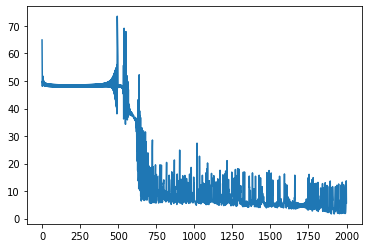

In [5]:

net = network([2, 3, 3, 1])

x,y = np.meshgrid(np.linspace(-1,1,20), np.linspace(0,1,10))

inputs = np.array([x.ravel(), y.ravel()]).T
outputs = np.less(x**2 + y**2, 0.5).reshape(200, 1).astype(int)

net.train(inputs, outputs, 0.1, 2000)

plt.plot(net.epoch_history, net.error_history)
plt.show()

In [6]:
def colour_classify(data, boundary_value):
    COLOR1 = [0, 0, 1]
    COLOR2 = [1, 0, 0]
    colour = np.less(data, boundary_value).flatten().astype(int)
    colour = np.array([COLOR1 if c == 1 else COLOR2 for c in colour])
    return colour

Epoch 0/5000, Loss: 50.25559334375076
Epoch 1000/5000, Loss: 8.264289339099033
Epoch 2000/5000, Loss: 5.088448177268509
Epoch 3000/5000, Loss: 5.056546837980028
Epoch 4000/5000, Loss: 2.5853130658742427
Final Error:  0.4420414142708975


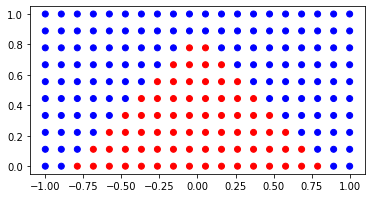

In [7]:
net = network([2, 3, 3, 1])

output_history = []

def epoch_callback(net):
    output_history.append(net.outputs(inputs))

net.train(inputs, outputs, 0.1, 5000, epoch_callback)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y)
scatter.set_color(colour_classify(output_history[0], 0.5))
plt.axis('scaled')

## Animation of the network learning
def animate(i):
    data = output_history[i % len(output_history)]    
    scatter.set_color(colour_classify(data, 0.5))
    scatter.set_label(f"Epoch {i} Error: {net.error_history[i]}")
    return scatter

ani1 = animation.FuncAnimation(fig, animate, interval=100)
HTML(ani1.to_html5_video())


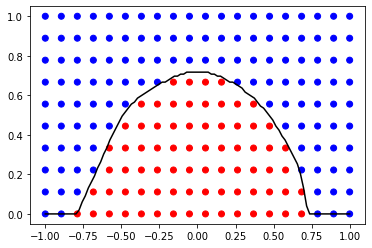

In [8]:
ysamples = 100

def get_boundary(x, net):
    ## returns y values at given x values at the class boundary
    ypos = np.linspace(0, 1, ysamples)
    xgrid, ygrid = np.meshgrid(x, ypos)
    sample_input = np.array([xgrid.ravel(), ygrid.ravel()]).T
    sample_output = net.outputs(sample_input).reshape(ysamples, x.size)
    y = ypos[np.argmin(abs(sample_output - 0.5), axis = 0)]
    return y

x_boundary = np.linspace(-1, 1, 100)
y_boundary = get_boundary(x_boundary, net)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y)
scatter.set_color(colour_classify(net.outputs(inputs), 0.5))
plt.plot(x_boundary, y_boundary, color = 'black')
plt.show()


Epoch 0/2000, Loss: 55.869342894047364
Epoch 400/2000, Loss: 49.05236020525274
Epoch 800/2000, Loss: 6.654837407296723
Epoch 1200/2000, Loss: 2.4241006776017366
Epoch 1600/2000, Loss: 0.08158323600462586


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Final Error:  0.028745147280895725


IndexError: list index out of range

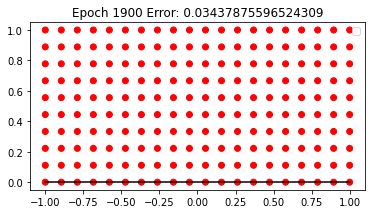

In [9]:
net = network([2, 3, 3, 1])



x_boundary_line = np.linspace(-1, 1, 100)
y_boundary_lines = []

output_history = []

def epoch_callback(net):
    y_boundary_lines.append(get_boundary(x_boundary_line, net))
    output_history.append(net.outputs(inputs))

interval = 100
net.train(inputs, outputs, 0.1, 2000, epoch_callback, interval)

fig, ax = plt.subplots()

scatter = ax.scatter(x, y)
scatter.set_color(colour_classify(output_history[0], 0.5))
ax.set_title(f"Epoch {0} Error: {net.error_history[0]}")
boundary_line = ax.plot(x_boundary_line, y_boundary_lines[0], color="black")[0]
plt.axis('scaled')
plt.legend()

## Animation of the network learning
def animate(i):
    data = output_history[interval * i % len(output_history)]    
    scatter.set_color(colour_classify(data, 0.5))
    boundary_line.set_ydata(y_boundary_lines[interval * i % len(y_boundary_lines)])
    ax.set_title(f"Epoch {interval * i} Error: {net.error_history[interval * i]}")
    return scatter

ani2 = animation.FuncAnimation(fig, animate, interval=100)
HTML(ani2.to_html5_video())
# ani2.save("point_classifying.mp4")